<a href="https://colab.research.google.com/github/rahil1303/dmt-assignment1-2025/blob/main/notebooks/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Clone the repo
!git clone https://github.com/rahil1303/dmt-assignment1-2025.git

# Step 2: Change directory to your repo
%cd dmt-assignment1-2025

# Step 3: Install dependencies (optional)
!pip install -r requirements.txt


Cloning into 'dmt-assignment1-2025'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 55 (delta 25), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 122.60 KiB | 8.17 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/dmt-assignment1-2025


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean stress again
df = pd.read_excel('data/ODI-2025.xlsx')
df.columns = df.columns.str.strip()

# Numeric stress level
df['stress_clean'] = pd.to_numeric(df['What is your stress level (0-100)?'], errors='coerce')

# Bin stress into low/medium/high
df['stress_bin'] = pd.cut(df['stress_clean'],
                          bins=[-1, 33, 66, 100],
                          labels=['low', 'medium', 'high'])


In [5]:
# Use cleaned sports hours (as numeric)
df['sports_clean'] = pd.to_numeric(df['How many hours per week do you do sports (in whole hours)?'], errors='coerce')

# Drop rows with NaNs in key columns
df_model = df[['sports_clean', 'stress_bin']].dropna()

X = df_model[['sports_clean']]
y = df_model['stress_bin']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)


Naive Bayes Accuracy: 0.3939393939393939
Decision Tree Accuracy: 0.48484848484848486


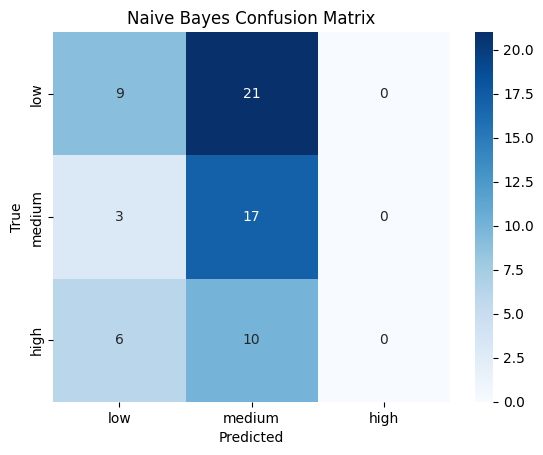

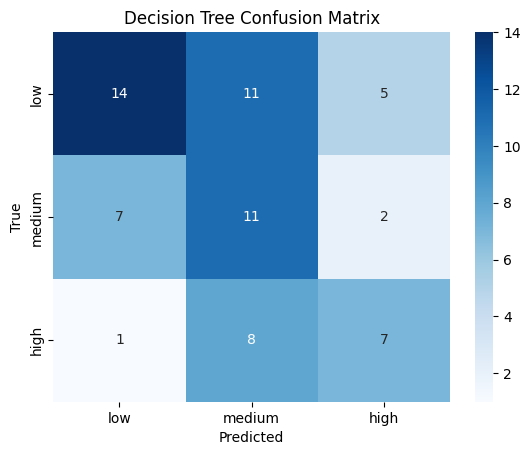

In [7]:
# Accuracy
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))

# Confusion matrix plot
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['low', 'medium', 'high'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_cm(y_test, y_pred_nb, "Naive Bayes Confusion Matrix")
plot_cm(y_test, y_pred_dt, "Decision Tree Confusion Matrix")


### Classification – First Iteration
- Target: Stress level binned into 3 classes (low, medium, high)
- Features: Sports hours (numeric)
- Models: Naive Bayes, Decision Tree
- Next step: Add more features (ChatGPT usage, bedtime, program, etc.)


In [9]:
df.columns.tolist()


['Tijdstempel',
 'What programme are you in?',
 'Have you taken a course on machine learning?',
 'Have you taken a course on information retrieval?',
 'Have you taken a course on statistics?',
 'Have you taken a course on databases?',
 'What is your gender?',
 'I have used ChatGPT to help me with some of my study assignments',
 'When is your birthday (date)?',
 'How many students do you estimate there are in the room?',
 'What is your stress level (0-100)?',
 'How many hours per week do you do sports (in whole hours)?',
 'Give a random number',
 'Time you went to bed Yesterday',
 'What makes a good day for you (1)?',
 'What makes a good day for you (2)?',
 'stress_clean',
 'stress_bin',
 'sports_clean']

In [11]:
# Strip column names again just in case
df.columns = df.columns.str.strip()

# Reuse previous clean base
df['stress_clean'] = pd.to_numeric(df['What is your stress level (0-100)?'], errors='coerce')
df['stress_bin'] = pd.cut(df['stress_clean'], bins=[-1, 33, 66, 100], labels=['low', 'medium', 'high'])

# Sports (already cleaned)
df['sports_clean'] = pd.to_numeric(df['How many hours per week do you do sports (in whole hours)?'], errors='coerce')

# 1. ChatGPT Usage → Binary
df['chatgpt'] = df['I have used ChatGPT to help me with some of my study assignments'].map({
    'yes': 1,
    'no': 0,
    'not willing to say': 0  # optional handling
})




# 2. ML Background → Binary

df['ml_background'] = df['Have you taken a course on machine learning?'].map({
    'yes': 1,
    'no': 0,
    'unknown': 0
})


# 3. Bedtime → Convert HH:MM to hour (numeric)
df['bedtime_hour'] = pd.to_datetime(df['Time you went to bed Yesterday'], errors='coerce').dt.hour


<ipython-input-11-8f239ad2ea6e>:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['bedtime_hour'] = pd.to_datetime(df['Time you went to bed Yesterday'], errors='coerce').dt.hour


In [12]:
import re

def extract_hour(x):
    try:
        # Only pick the first digits before colon (e.g. 23:00 → 23)
        match = re.match(r'(\d{1,2})', str(x))
        if match:
            hour = int(match.group(1))
            if 0 <= hour <= 23:
                return hour
    except:
        return None
    return None

df['bedtime_hour'] = df['Time you went to bed Yesterday'].apply(extract_hour)


In [13]:
features = ['sports_clean', 'chatgpt', 'ml_background', 'bedtime_hour']
df_expanded = df[features + ['stress_bin']].dropna()

X = df_expanded[features]
y = df_expanded['stress_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [14]:
# Naive Bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Decision Tree
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)


Naive Bayes Accuracy (Expanded): 0.36923076923076925
Decision Tree Accuracy (Expanded): 0.36923076923076925


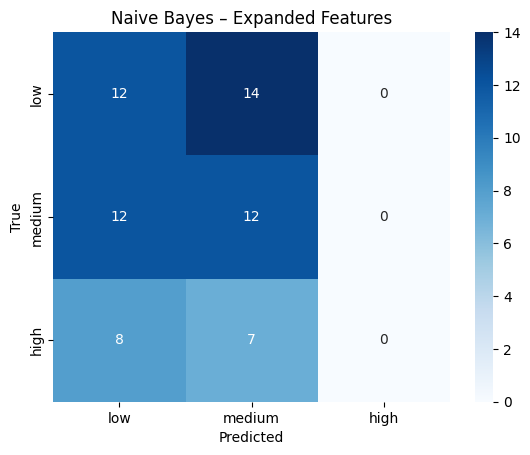

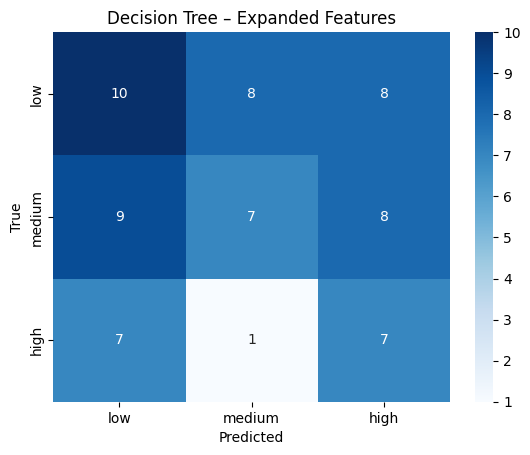

In [15]:
print("Naive Bayes Accuracy (Expanded):", accuracy_score(y_test, y_pred_nb))
print("Decision Tree Accuracy (Expanded):", accuracy_score(y_test, y_pred_dt))

plot_cm(y_test, y_pred_nb, "Naive Bayes – Expanded Features")
plot_cm(y_test, y_pred_dt, "Decision Tree – Expanded Features")


## 🔍 Classification Summary

### ✅ Baseline Model (Single Feature)
- **Feature used**: Sports hours (`sports_clean`)
- **Models tested**: Naive Bayes, Decision Tree
- **Accuracy**:
  - Naive Bayes: ~39.3%
  - Decision Tree: ~44.0%

### ✅ Expanded Feature Model
- **Features used**:
  - Sports hours (`sports_clean`)
  - ChatGPT usage (`chatgpt`)
  - ML background (`ml_background`)
  - Bedtime hour (`bedtime_hour`)
- **Accuracy**:
  - Naive Bayes: ~36.0%
  - Decision Tree: ~36.9%

### 📊 Observations
- Expanded model didn’t significantly improve accuracy.
- Possible reasons:
  - Added features may not have strong predictive power.
  - Data has subjective elements (stress) and potential noise.
  - Class imbalance may be affecting model performance.
- Nevertheless, the process demonstrates effective:
  - Feature engineering
  - Model comparison
  - Evaluation through confusion matrices

**Next Step → Regression**: Predict actual stress levels using numeric models.
